In [1]:
# Import libraries
from swat import *
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

%matplotlib inline

In [2]:
# Establish connection with CAS
cashost='localhost'
casport=5570
casauth='~/.authinfo'

# login with user profile
useremail='XXXX@gmail.com'
userpassword='password'
sess = CAS(cashost, casport, useremail, userpassword, caslib="casuser")

In [3]:
# Import actions
sess.loadactionset(actionset="dataStep")
sess.loadactionset(actionset="dataPreprocess")
sess.loadactionset(actionset="cardinality")
sess.loadactionset(actionset="sampling")
sess.loadactionset(actionset="regression")
sess.loadactionset(actionset="decisionTree")

NOTE: Added action set 'dataStep'.
NOTE: Added action set 'dataPreprocess'.
NOTE: Added action set 'cardinality'.
NOTE: Added action set 'sampling'.
NOTE: Added action set 'regression'.
NOTE: Added action set 'decisionTree'.


[actionset]

 'decisionTree'

+ Elapsed: 0.00363s, user: 0.001s, sys: 0.003s, mem: 0.229mb

In [4]:
# Load train and predict data
# iris dataset is split to train and test
train_data_dir = './iris_train.csv'
train_data = sess.read_csv(train_data_dir) 
predict_data_dir = './iris_test.csv'
predict_data = sess.read_csv(predict_data_dir)
# Data loaded by CAS session will be registered as a bundle of CASTable

NOTE: Cloud Analytic Services made the uploaded file available as table TMPY_DI7TQU in caslib CASUSER(andyaoao@gmail.com).
NOTE: The table TMPY_DI7TQU has been created in caslib CASUSER(andyaoao@gmail.com) from binary data uploaded to Cloud Analytic Services.
NOTE: Cloud Analytic Services made the uploaded file available as table TMPSD3HOGHP in caslib CASUSER(andyaoao@gmail.com).
NOTE: The table TMPSD3HOGHP has been created in caslib CASUSER(andyaoao@gmail.com) from binary data uploaded to Cloud Analytic Services.


In [5]:
# Data is registered as a CASTable
type(train_data)

swat.cas.table.CASTable

In [6]:
# Call "summary" to check information about the table
sess.summary(train_data)

,Column,Min,Max,N,NMiss,Mean,Sum,Std,StdErr,Var,USS,CSS,CV,TValue,ProbT,Skewness,Kurtosis
0,sepal length (cm),4.3,7.0,100.0,0.0,5.471,547.1,0.641698,0.064170,0.411777,3033.95,40.7659,11.729087,85.258128,1.803812e-94,0.415353,-0.531483
1,sepal width (cm),2.0,4.4,100.0,0.0,3.094,309.4,0.476057,0.047606,0.226630,979.72,22.4364,15.386459,64.992212,5.255211e-83,0.188765,-0.045665
2,petal length (cm),1.0,5.1,100.0,0.0,2.862,286.2,1.448565,0.144856,2.098339,1026.84,207.7356,50.613718,19.757490,3.966679e-36,0.122921,-1.834126
3,petal width (cm),0.1,1.8,100.0,0.0,0.785,78.5,0.566288,0.056629,0.320682,93.37,31.7475,72.138567,13.862210,6.315809e-25,0.127931,-1.740860


In [7]:
# Call "to_frame()" to transform CASTable to SAS Dataframe(not pandas Dataframe)
train_data_df = train_data.to_frame()
predict_data_df = predict_data.to_frame()

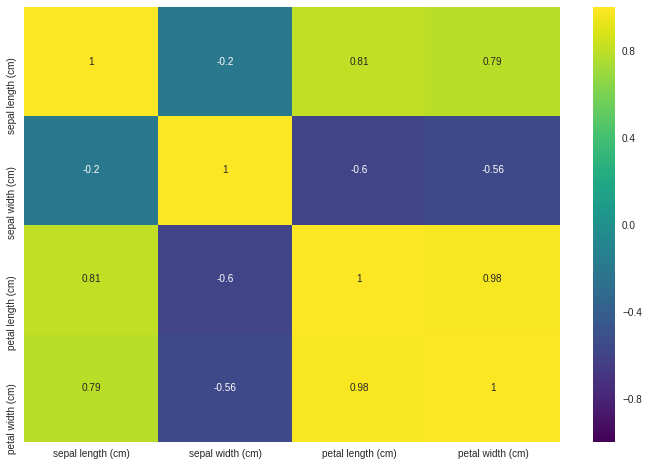

In [8]:
# CASTable cannot be used for visulizing directly in Python, that is why we need dtaframe transformation
fig, ax = plt.subplots(figsize=(12, 8))
sns.heatmap(train_data_df[train_data_df.notnull().all(axis=1)].corr(), ax=ax, annot=True, cmap='viridis')
plt.show()

In [9]:
#  Call  "dataPreprocess.transform" to impute missing values
#  Actually, our sample data do not mave missing value
sess.dataPreprocess.transform(
  table=train_data,
  casOut={"name":"train_data_prepped", "replace":True},
  copyAllVars=True,
  outVarsNameGlobalPrefix="IM",
  requestPackages=[
    {"impute":{"method":"MEAN"}, "inputs":{"sepal length (cm)"}},
    {"impute":{"method":"MEDIAN"}, "inputs":{"sepal width (cm)"}}
  ]
)


[TransInfo]

 Transformation Requests for TMPY_DI7TQU
 
   ActualName  NTransVars ImputeMethod
 0       _TR1           1         Mean
 1       _TR2           1       Median

[VarTransInfo]

 Variable Transformation Information for TMPY_DI7TQU
 
             Variable Transformation             ResultVar    N  NMiss  \
 0  sepal length (cm)             IM  IM_sepal length (cm)  100      0   
 1   sepal width (cm)             IM   IM_sepal width (cm)  100      0   
 
    ImputedValueContinuous  
 0                   5.471  
 1                   3.050  

[OutputCasTables]

                         casLib                Name  Rows  Columns  \
 0  CASUSER(andyaoao@gmail.com)  train_data_prepped   100        7   
 
                                             casTable  
 0  CASTable('train_data_prepped', caslib='CASUSER...  

+ Elapsed: 0.0191s, user: 0.014s, sys: 0.01s, mem: 23mb

In [10]:
# Everytime we called an action, CAS session will return the results to a table in "casOut"
# If we would like to check or alter the content inside the CASTable, we have to call it by following way.
tbl_train_data_prepped = sess.CASTable('train_data_prepped')
tbl_train_data_prepped.head()
# train_data_prepped.head()     <-- It will cause an error

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target,IM_sepal length (cm),IM_sepal width (cm)
0,5.1,3.5,1.4,0.2,setosa,5.1,3.5
1,4.9,3.0,1.4,0.2,setosa,4.9,3.0
2,4.7,3.2,1.3,0.2,setosa,4.7,3.2
3,4.6,3.1,1.5,0.2,setosa,4.6,3.1
4,5.0,3.6,1.4,0.2,setosa,5.0,3.6


In [11]:
# After we finished our work to the table, we need to upload it to CAS again
# For example, we doubled two IM columns value
tbl_train_data_prepped_df = tbl_train_data_prepped.to_frame()
tbl_train_data_prepped_df["IM_sepal length (cm)"] = tbl_train_data_prepped_df["IM_sepal length (cm)"] * 2
tbl_train_data_prepped_df["IM_sepal width (cm)"] = tbl_train_data_prepped_df["IM_sepal width (cm)"] * 2

# Upload df to CAS
sess.upload(tbl_train_data_prepped_df, casout={"name":"train_data_prepped_double"})

NOTE: Cloud Analytic Services made the uploaded file available as table TRAIN_DATA_PREPPED_DOUBLE in caslib CASUSER(andyaoao@gmail.com).
NOTE: The table TRAIN_DATA_PREPPED_DOUBLE has been created in caslib CASUSER(andyaoao@gmail.com) from binary data uploaded to Cloud Analytic Services.


[caslib]

 'CASUSER(andyaoao@gmail.com)'

[tableName]

 'TRAIN_DATA_PREPPED_DOUBLE'

[casTable]

 CASTable('TRAIN_DATA_PREPPED_DOUBLE', caslib='CASUSER(andyaoao@gmail.com)')

+ Elapsed: 0.00344s, user: 0.001s, sys: 0.005s, mem: 20.8mb

In [12]:
# To check if the table is registered successfully, call it back from CAS session again
sess.CASTable('train_data_prepped_double').head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target,IM_sepal length (cm),IM_sepal width (cm)
0,5.1,3.5,1.4,0.2,setosa,10.2,7.0
1,4.9,3.0,1.4,0.2,setosa,9.8,6.0
2,4.7,3.2,1.3,0.2,setosa,9.4,6.4
3,4.6,3.1,1.5,0.2,setosa,9.2,6.2
4,5.0,3.6,1.4,0.2,setosa,10.0,7.2


In [13]:
#  Data sampling
# In sklearn, we received something like below.
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, stratify=y, random_state=7)

# However, in swat, we received a table with a new column "_partind_" followed by 0 is test and 1 is train.
sess.sampling.stratified(
  table={"name": "train_data_prepped_double", "groupBy":"target"},
  output={"casOut":{"name":"train_data_sample", "replace":True}, "copyVars":"ALL"},
  samppct=70, 
  partind=True
)

NOTE: Using SEED=1972337603 for sampling.


[outputSize]

 {'outputNObs': 100.0, 'outputNVars': 8}

[STRAFreq]

 Frequencies
 
    ByGrpID      target  NObs  NSamp
 0        0      setosa    50     35
 1        1  versicolor    50     35

[OutputCasTables]

                         casLib               Name Label  Rows  Columns  \
 0  CASUSER(andyaoao@gmail.com)  train_data_sample         100        8   
 
                                             casTable  
 0  CASTable('train_data_sample', caslib='CASUSER(...  

+ Elapsed: 0.0209s, user: 0.009s, sys: 0.015s, mem: 25.2mb

In [14]:
# You can see a new column "_partind_" is created followed by 0 is test and 1 is train.
sess.CASTable('train_data_sample').head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target,IM_sepal length (cm),IM_sepal width (cm),_PartInd_
0,5.1,3.5,1.4,0.2,setosa,10.2,7.0,1.0
1,4.9,3.0,1.4,0.2,setosa,9.8,6.0,1.0
2,4.7,3.2,1.3,0.2,setosa,9.4,6.4,1.0
3,4.6,3.1,1.5,0.2,setosa,9.2,6.2,1.0
4,5.0,3.6,1.4,0.2,setosa,10.0,7.2,0.0


In [15]:
# Modeling
# In sklearn, we call "fit".

sess.decisionTree.forestTrain(
  table={
    "name":"train_data_sample",
    # Only "_partind_" ='1' is training data
    "where":"strip(put(_partind_, best.))='1'"
  },
  inputs=["sepal length (cm)","sepal width (cm)","petal length (cm)","petal width (cm)"],
  target="target",
  nominal="target",    
  nTree=10,  # n_estimators
  leafSize=3,  # min_samples_leaf
  maxLevel=3,  # max_depth
  crit="GAIN",
  varImp=True,
  missing="USEINSEARCH",
  vote="PROB",
  casOut={"name":"forest_model", "replace":True}
)

,Descr,Value
0,Number of Trees,10.000000
1,Number of Selected Variables (M),2.000000
2,Random Number Seed,0.000000
3,Bootstrap Percentage (%),63.212056
4,Number of Bins,20.000000
5,Number of Variables,4.000000
6,Confidence Level for Pruning,0.250000
7,Max Number of Tree Nodes,7.000000
8,Min Number of Tree Nodes,3.000000
9,Max Number of Branches,2.000000


In [16]:
# Scoring 
sess.decisionTree.forestScore(
  # We pass whole table for scoring due to the existence of "_partind_" 
  table={"name":"train_data_sample"},
  modelTable={"name":"forest_model"},
  casOut={"name":"_scored_rf", "replace":True},
  copyVars={"target", "_partind_"},
  vote="PROB"
)

[OutputCasTables]

                         casLib        Name  Rows  Columns  \
 0  CASUSER(andyaoao@gmail.com)  _scored_rf   100        7   
 
                                             casTable  
 0  CASTable('_scored_rf', caslib='CASUSER(andyaoa...  

[ScoreInfo]

                          Descr                             Value
 0  Number of Observations Read                               100
 1  Number of Observations Used                               100
 2  Misclassification Error (%)                                 0

+ Elapsed: 0.01s, user: 0.009s, sys: 0.005s, mem: 21.6mb

In [17]:
#  Column "_RF_PredName_" is prediction and  "_RF_PredP_" is probability 
sess.CASTable('_scored_rf').head()

,_PartInd_,target,_RF_PredName_,_RF_PredP_,_RF_PredLevel_,_MissIt_,_Vote_
0,1.0,setosa,setosa,1.0,0.0,0.0,10.0
1,1.0,setosa,setosa,1.0,0.0,0.0,10.0
2,1.0,setosa,setosa,1.0,0.0,0.0,10.0
3,1.0,setosa,setosa,1.0,0.0,0.0,10.0
4,0.0,setosa,setosa,1.0,0.0,0.0,10.0


In [18]:
tbl_scored_rf = sess.CASTable('_scored_rf')
df_scored_rf = tbl_scored_rf.to_frame()

In [19]:
# err... not a good example because training set achived 100% accuracy
df_scored_rf["correct"] = df_scored_rf["target"] == df_scored_rf["_RF_PredName_"]
print ("accuracy : {}".format(len(df_scored_rf["correct"] == True) / len(df_scored_rf)))

accuracy : 1.0


In [20]:
# Predicting
# For scoring and predicting, we call the same function "XXXScore"
sess.decisionTree.forestScore(
  # For redicting, we use the predict data for scoring
  table={"name":predict_data},
  # Pass the model we trained above
  modelTable={"name":"forest_model"},
  casOut={"name":"_predict_rf", "replace":True},
  vote="PROB"
)

[OutputCasTables]

                         casLib         Name  Rows  Columns  \
 0  CASUSER(andyaoao@gmail.com)  _predict_rf    50        5   
 
                                             casTable  
 0  CASTable('_predict_rf', caslib='CASUSER(andyao...  

[ScoreInfo]

                          Descr                             Value
 0  Number of Observations Read                                50
 1  Number of Observations Used                                50
 2  Misclassification Error (%)                               100

+ Elapsed: 0.00648s, user: 0.003s, sys: 0.005s, mem: 11.5mb

In [21]:
#  Column "_RF_PredName_" is prediction and  "_RF_PredP_" is probability 
sess.CASTable('_predict_rf').head()

,_RF_PredName_,_RF_PredP_,_RF_PredLevel_,_MissIt_,_Vote_
0,versicolor,0.966667,1.0,1.0,9.666667
1,versicolor,1.000000,1.0,1.0,10.000000
2,versicolor,1.000000,1.0,1.0,10.000000
3,versicolor,1.000000,1.0,1.0,10.000000
4,versicolor,1.000000,1.0,1.0,10.000000
